# Module 2 - Statistics with python
---------------------------------------------------

This notebook aims to present how to perform classical statiscial procedure as well as some amount of regression using various python libraries, such as `scipy`.

It **does not aim to replace a course on statistics**, but rather focuses on the code aspect.

In [1]:
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns
import scipy.stats as stats 
import pandas as pd
import numpy as np
print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
import matplotlib as mpl
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 16}

mpl.rc('font', **font)

<br>

# Table of Content <a id='toc'></a>

<br>

1. [SciPy.stats and statistics in python](#stats)

    1.1 [manipulation of random distributions](#stats.1)

    1.1.1 [Drawing some random numbers : rvs](#stats.1.1)

    1.1.2 [Looking up the quantiles and probability density functions](#stats.1.2)

    1.2 [t-test](#stats.2)

    1.3 [statistical power calculations](#stats.3)

    1.4 [Multiple hypothesis testing](#stats.4)

    1.5 [Fisher's exact test and the Chi-square test](#stats.5)

    1.6 [1-way anova](#stats.6)


2. [Correlation and linear regression](#reg)

    2.1 [Correlation](#reg.1)

    2.2 [Regression](#reg.2)

[Free form exercise](#exo)

<br>
<br>

# 1. `scipy.stats` and statistics in python <a id='stats'></a>
-----------------------------------------------------------

**[SciPy](https://scipy.org)** is a comprehensive project for scientific python programming, regrouping a [library](https://docs.scipy.org/doc/scipy/reference/) and implementing various tools and algorithm for scientific software.

This section gives a primer on the **`scipy.stats`** library, which provides ways to interact with various random distribution functions, and implements numerous statistical tests.

<br>


## 1.1 manipulation of random distributions <a id='stats.1'></a>

The **`scipy.stats`** module implements utilities for a large number of continuous and discrete distributions:

In [3]:
from scipy import stats

dist_continu = [d for d in dir(stats) if isinstance(getattr(stats, d), stats.rv_continuous)]
dist_discrete = [d for d in dir(stats) if isinstance(getattr(stats, d), stats.rv_discrete)]
print('number of continuous distributions: %d' % len(dist_continu))
print('number of discrete distributions:   %d' % len(dist_discrete))


number of continuous distributions: 104
number of discrete distributions:   19


let's experiment with the normal distribution, or `norm` in `scipy.stats`

A look at `help(stats.norm)` tells us that:
* The **`loc`** argument (location) specifies the **mean** of the distribution.
* The **`scale`** argument specifies the **standard deviation** of the distribution.

<br>

**Example:** generate a specific normal distribution with a mean of 10 and a stdev of 2:

In [4]:
N = stats.norm(loc=10, scale=2)

# The mean and variance of a distribution can be retrieved using the .stats method :
print("Type of N is:", type(N))
print("Mean and standard deviation:", N.stats())


Type of N is: <class 'scipy.stats._distn_infrastructure.rv_frozen'>
Mean and standard deviation: (array(10.), array(4.))


The scipy distribution object (`N` in our example) can then be used to interact with the distribution in many ways, as illustrated below.

<br>

### 1.1.1. Drawing random numbers: `rvs` <a id='stats.1.1'></a>

The **`rvs()`** method allows to draw a random number of values from a distribution.
* The `size` argument is 1 or several integers and defines the dimensions of the returned arrays of
  random numbers.

In [5]:
N.rvs(size=[50]) 

array([ 9.42820573,  8.77564601,  7.53792921,  9.36972609, 10.23263376,
        6.69095386,  9.97134653, 11.80199524,  7.05570949,  7.7206921 ,
       10.94571627,  8.2649163 ,  7.9475298 ,  9.51250588,  8.92203675,
       13.85814145,  9.67710857,  9.91870663,  8.59379255, 10.59229596,
       10.42213801, 12.31051958,  9.2151355 , 11.38908754, 10.40196913,
        7.70500037,  7.00599876,  9.91480978,  8.15361168, 10.61808824,
       10.55747422, 14.08154287,  9.70780581, 13.18596395, 10.63451277,
       11.60105892,  6.74339516, 10.5622089 , 10.13444082,  6.62933188,
       10.3754328 ,  9.15348392,  8.38721396,  9.73803915, 11.90030721,
        9.89708646,  8.52595455, 10.55236126, 13.3182553 , 11.72734581])

(array([  25.,  126.,  418.,  947., 1327., 1242.,  647.,  228.,   37.,
           3.]),
 array([ 3.33497935,  4.75135995,  6.16774055,  7.58412115,  9.00050176,
        10.41688236, 11.83326296, 13.24964356, 14.66602417, 16.08240477,
        17.49878537]),
 <BarContainer object of 10 artists>)

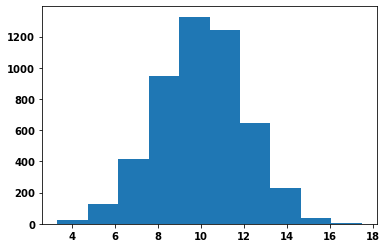

In [6]:
plt.hist(N.rvs(size=[5000])) 

**Warning:** as with any drawing of random variable on a computer, [one merely emulates randomness](https://en.wikipedia.org/wiki/Pseudorandom_number_generator).  

The positive aspect of using pseudo-random numbers is that one can make random operation reproducible by setting up **random seed**.

In [7]:
import numpy as np

# Set the random seed and draw 5 random numbers:
np.random.seed(2021)   
draw1 = N.rvs(size=5)

# Set the random seed back to the same value as above -> 2021.
np.random.seed(2021)
draw2 = N.rvs(size=5)

print("Are the random draws equal?", all(draw1 == draw2))
print(draw1)
print(draw2)

Are the random draws equal? True
[12.97721811 11.35202174  9.16309726  8.38695837 11.11175166]
[12.97721811 11.35202174  9.16309726  8.38695837 11.11175166]


<br>

### 1.1.2 Looking-up quantiles and probability density functions <a id='stats.1.2'></a>

* **`pdf()`**: Probability Density Function.
* **`cdf()`**: Cumulative Distribution Function.
* **`ppf()`**: Percent Point Function (inverse of CDF), gives the quantiles of the distribution.

<br>

**Example:** using the PDF to plot a distribution.

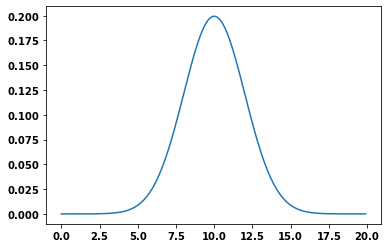

In [8]:
import matplotlib.pyplot as plt 

X = np.arange(0, 20, 0.1)      # generate a sequence ranging from 0 to 20 with increment of 0.1
plt.plot(X, N.pdf(X))          # for each element of the sequence, get the associated PDF value.
plt.show()

<br>

**Example:** using the CDF to estimate a probability, using PPF to compute quantiles.

In [9]:
# cdf: Cumulative Distribution Function.
print('What is the probability of drawing a number <= 15.0 ?', N.cdf(15.0))

# ppf: gives the quantiles of the distribution.
P = [0.025, 0.5, 0.975]
Q = N.ppf(P)
print('Quantiles:', P, '->', Q)

What is the probability of drawing a number <= 15.0 ? 0.9937903346742238
Quantiles: [0.025, 0.5, 0.975] -> [ 6.08007203 10.         13.91992797]


<br>

For **discrete distribution** these rules change a bit: `pdf()` is replaced by `pmf()`.

Let's see an example of **binomial distribution** with 10 draws and a 0.5 probability of success:

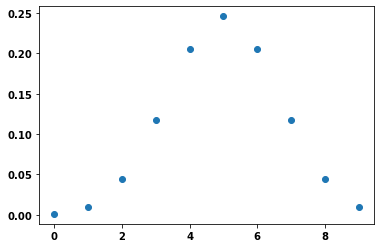

In [10]:
X = np.arange(0,10)
plt.scatter(X, stats.binom.pmf(X, n=10, p=0.5))
plt.show()

Most distributions have a certain number of **parameters** which may control their overall **shape, location or scale**.
* The **normal law** e.g. has two parameters: its mean ($\mu$) and its standard deviation ($\sigma$), 
  which respectively control its location and scale. In `scipy`, these are set via the `loc` (location)
  and `scale` arguments.

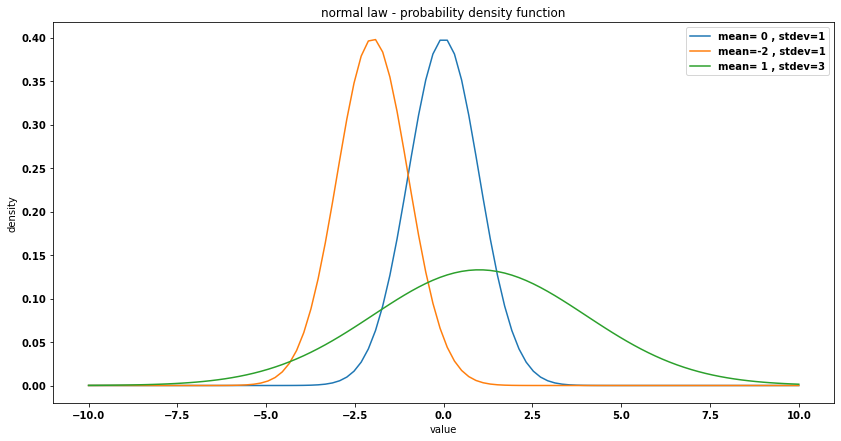

In [11]:
x = np.linspace(-10,10, 100) # 100 equally separated points between -5 and 5
fig, ax = plt.subplots(figsize=(14, 7))

a= sns.lineplot(x=x, y=stats.norm.pdf(x , 
                                      loc = 0 , scale = 1) ,
                ax = ax , label='mean= 0 , stdev=1')
sns.lineplot(x=x, y=stats.norm.pdf(x , loc = -2 , scale = 1 ) ,
             ax = ax , label='mean=-2 , stdev=1')
sns.lineplot(x=x, y=stats.norm.pdf(x , loc = 1 , scale = 3 ) ,
             ax = ax , label='mean= 1 , stdev=3')

a.set(xlabel='value', ylabel='density')
a.set_title('normal law - probability density function')
ax.legend()

<br>
<br>

[back to toc](#toc)

## 1.2 t-test <a id='stats.2'></a>

The **t-test** is used to determine if the means of two samples (drawn from 2 sub-populations for instance) are significantly different.

It is a widely used test, with important but not overly complex assumptions:
 * Independence of data points.
 * The means of each sample should follow normal distributions.
 * *The two sample share the came variance* <- there are different flavors of the t-test depending
   on that assumption.

<br>

**Example:** weight of mices of different genotypes and subjected to different diets.

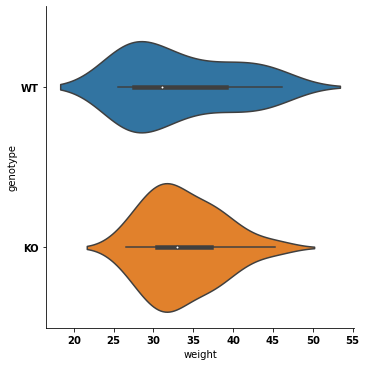

In [12]:
mice_data = pd.read_csv('data/mice_data.csv')
sns.catplot(x='weight' , y='genotype' , data=mice_data , kind='violin')

In [13]:
WTdata = mice_data['weight'][ mice_data['genotype'] == 'WT' ]
KOdata = mice_data['weight'][ mice_data['genotype'] == 'KO' ]

tstat , pval = stats.ttest_ind( KOdata , WTdata , 
                               equal_var=False)
#use equal_var=True if you have tested for variance equality
print('test statistic: ',tstat , sep='\t')
print('p-value : ',pval , sep='\t')

test statistic: 	0.18836850422505863
p-value : 	0.8514498629523397


<br>

### Micro-Exercise:
* There is another column in the data-set : `diet`, which can take the values `"HFD"` and `"CHOW"`.
  Perform a t-test exactly as before, but splitting mice by their `diet` rather than their `genotype`.

<br>
<br>

[back to toc](#toc)

## 1.3 Statistical power calculations <a id='stats.3'></a>


For some widely used tests, functions exist to let you automatically compute statistical power for a given effect size or sample size.

In [16]:
from statsmodels.stats.power import TTestIndPower

mean_difference=1
standard_dev=1
sample_size=10

effect_size = mean_difference/standard_dev

P = TTestIndPower()
print('power:', P.power(effect_size=effect_size, 
                        nobs1=sample_size, 
                        ratio=1 , alpha=0.05) )

power: 0.5620066386966457


**Calculating statistical power can help inform our experimental design**. 

For example, how many observation per sample do we need if we want to detect a difference in mean of 1 with significance level (type I error) 0.01 and statistical power 0.80:

minimum sample size: 25.066708773444212


/home/wandrille/Installed_software/anaconda3/envs/py38/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


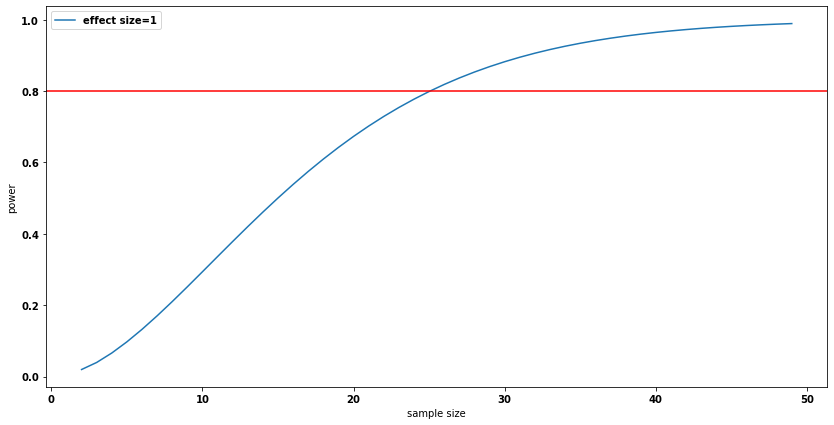

In [17]:
effect_size=1
sig_threshold = 0.01
P = TTestIndPower()

powers = []
for sample_size in range(2,50):
    powers.append( P.power(effect_size=effect_size , nobs1=sample_size , ratio=1 , alpha=sig_threshold) )

fig,ax=plt.subplots(figsize=(14,7))
sns.lineplot(range(2,50) , powers , label = 'effect size='+str(effect_size) , ax=ax)
ax.axhline(0.8, color='r', linestyle='-')
ax.set(xlabel='sample size', ylabel='power')


## or, directly:
print( 'minimum sample size:', P.solve_power(effect_size=effect_size , 
                                             nobs1=None ,  
                                             ratio=1 , 
                                             alpha=sig_threshold , 
                                             power = 0.8))

<br>
<br>

[back to toc](#toc)

## 1.4 Multiple hypothesis testing <a id='stats.4'></a>

Recall the definition of the p-value: the probability of obtaining a test statistic at least as extreme as the one observed, **if the null hypothesis is true**

Thus, *even* if the p-value is, let's say, 0.04, there is still a 4% chance of obtaining such an extreme result by chance.

This is often acceptable if we only perform one test. However when multiple tests are performed, it was shown  (by simulation), that even when there is no real effect some tests will turn out significant by chance.

> This is the definition of the $\alpha$ risk of type I error.

Of course, this has important implication for science and the relevance of our results.

![image.png](img/xkcd882.png)

> source: [xkcd](http://xkcd.com) (note: there are many relevant xkcd strips for everything related to stats/programming courses)

/home/wandrille/Installed_software/anaconda3/envs/py38/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 0, 'number of tests'),
 Text(0, 0.5, 'probability of at least 1 test significant by chance')]

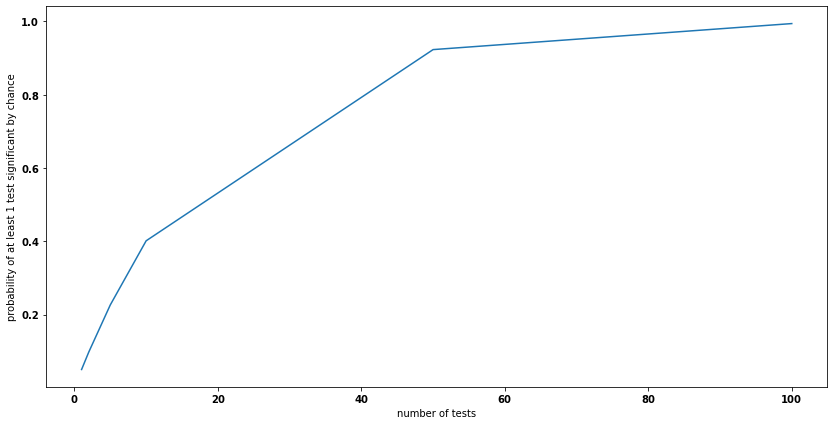

In [18]:
P = np.array([1, 2, 5, 10, 50, 100])
fig,ax=plt.subplots(figsize=(14,7))
sns.lineplot( P , 1- 0.95**P ,ax=ax)
ax.set(xlabel='number of tests', ylabel='probability of at least 1 test significant by chance')



We need to change perspective.
Instead of trying to limit the false positive probability for *each* test, we focus on:
* The probability of obtaining **any** false positives (family-wise error rate, **FWER**)
* The proportion of false positives among all findings (false discovery rate, **FDR**)

> Controlling the FWER is often too stringent - limit type I errors, but get lots of type II errors. 

<br>

### The Bonferroni method for controlling the FWER
* Assume we are performing $N$ tests
* To control the FWER at (e.g.) 0.05, only call variables with p-values below $0.05/N$ significant

<br>

### The Benjamini-Hochberg method for controlling the FDR

- Assume we are performing $N$ tests
- Intuition: for each p-value threshold $\alpha$, we can estimate the number of false discoveries by $\alpha N$
- Compare this to the actual number of discoveries at the threshold - $N_\alpha$
- Choose a p-value threshold $\alpha$ such that $\alpha N/N_\alpha$ is less than a desired threshold (e.g. 0.05) - this threshold would give an expected FDR of 0.05
- Note that the FDR is truly a property of a *set* - in a set of genes with FDR = 0.05, we can expect around 5% to be false discoveries. However, we don't know *which* ones! It could be the most significant!
- Often, we want a gene-wise measure of significance (like the p-value)
- The q-value, or adjusted p-value, of a variable is the *smallest* FDR we have to accept in order to call that variable significant.
- For example, if the adjusted p-value is 0.2, we have to accept that if we want to call this variable (and consequently, all variables with lower p-values) significant, there will be approximately 20% false discoveries among them.

In python :

```python
from statsmodels.stats.multitest import multipletests

# Bonferroni
rejected,fwers,alphacSidak,alphacBonf = multipletests(pvals, alpha=0.05, method='bonferroni')

# BH procedure
rejected,fdrs,alphacSidak,alphacBonf = multipletests(pvals, alpha=0.05, method='fdr_bh')

# Note: many other methods are available -> help(multipletests)
```

* rejected : true for hypothesis that can be rejected for the given alpha
* fwers|fdrs : p-values corrected for multiple tests
* alphacSidak : corrected alpha for Sidak method
* alphacBonf : corrected alpha for Bonferroni method
        

In [19]:
# Imagine we perform 10 000 tests of 10 000 random data-sets
pvals = []

N = 10000
mean_difference = 0 # no differences -> any detected difference is due to chance
sample_size = 100
std=1

for i in range(N):
    t , pval_ttest = stats.ttest_ind( np.random.randn( sample_size ) * std , 
                                     np.random.randn( sample_size ) * std + mean_difference ,equal_var=True)
    pvals.append(pval_ttest)
    
pvals = np.array(pvals)
# stats models proposes a function implementing numerous p-value correction methods
# https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html

from statsmodels.stats.multitest import multipletests

rejected,fwers,alphacSidak,alphacBonf = multipletests(pvals, alpha=0.05, method='bonferroni')
rejected,fdrs,alphacSidak,alphacBonf = multipletests(pvals, alpha=0.05, method='fdr_bh')

Fraction of (spuriously) significant tests:
p-value: 0.0496
FWER   : 0.0
FDR    : 0.0


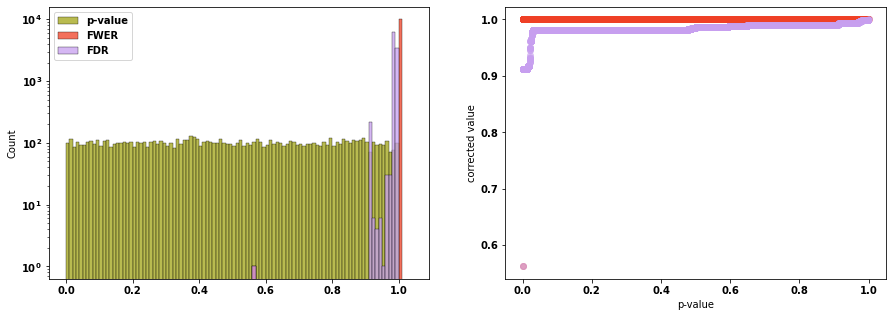

In [20]:
fig, ax = plt.subplots(1,2,figsize=(15, 5))
sns.histplot( pvals ,bins = np.arange(0,1.05,0.01) ,  ax = ax[0] , label = 'p-value' , color='xkcd:vomit')
sns.histplot( fwers ,bins = np.arange(0,1.05,0.01) ,   ax = ax[0] , label = 'FWER' , color='xkcd:tomato')
sns.histplot( fdrs  ,bins = np.arange(0,1.05,0.01) ,  ax = ax[0] , label = 'FDR' , color='xkcd:lavender')
ax[0].set_yscale('log')
ax[0].legend()

ax[1].scatter( pvals , fwers , label='FWER' , c='xkcd:tomato' , alpha=0.5)
ax[1].scatter( pvals , fdrs , label='FDR' , c='xkcd:lavender', alpha=0.5)
ax[1].set_xlabel('p-value')
ax[1].set_ylabel('corrected value')

print('Fraction of (spuriously) significant tests:')
print('p-value:' , sum(pvals<0.05)/N )
print('FWER   :' , sum(fwers<0.05)/N )
print('FDR    :' , sum(fdrs <0.05)/N )

In [21]:
# Now, imagine a different scenario where 100 out of the 10 000 tests 
pvals = []

N = 10000 - 100
mean_difference = 0 # no differences -> any detected difference is due to chance
sample_size = 100
std=1

for i in range(N):
    t , pval_ttest = stats.ttest_ind( np.random.randn( sample_size ) * std , 
                                     np.random.randn( sample_size ) * std + mean_difference ,equal_var=True)
    pvals.append(pval_ttest)

# now we add the different ones:
mean_difference = 0.75
for i in range(100):
    t , pval_ttest = stats.ttest_ind( np.random.randn( sample_size ) * std , 
                                     np.random.randn( sample_size ) * std + mean_difference ,equal_var=True)
    pvals.append(pval_ttest)

    
    
pvals = np.array(pvals)
# stats models proposes a function implementing numerous p-value correction methods
# https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html

from statsmodels.stats.multitest import multipletests

rejected,fwers,alphacSidak,alphacBonf = multipletests(pvals, alpha=0.05, method='bonferroni')
rejected,fdrs,alphacSidak,alphacBonf = multipletests(pvals, alpha=0.05, method='fdr_bh')

In [22]:
print('Number of significant tests:')
print('p-value:' , sum(pvals<0.05) )
print('FWER   :' , sum(fwers<0.05) )
print('FDR    :' , sum(fdrs <0.05) )
print()
print('Number of correctly significant tests (out of 100):')
print('p-value:' , sum(pvals[-100:]<0.05) )
print('FWER   :' , sum(fwers[-100:]<0.05) )
print('FDR    :' , sum(fdrs[-100:] <0.05) )
print()
print('Number of spuriously significant tests (out of 9900):')
print('p-value:' , sum(pvals[:-100]<0.05) )
print('FWER   :' , sum(fwers[:-100]<0.05) )
print('FDR    :' , sum(fdrs[:-100] <0.05) )

Number of significant tests:
p-value: 579
FWER   : 76
FDR    : 101

Number of correctly significant tests (out of 100):
p-value: 100
FWER   : 76
FDR    : 98

Number of spuriously significant tests (out of 9900):
p-value: 479
FWER   : 0
FDR    : 3


<br>
<br>

[back to toc](#toc)

## 1.5 Fisher's exact test and the Chi-square test <a id='stats.5'></a>

* These two tests have for object the association between 2 categorical variables.
* Their **null hypothesis** is the absence of association between the two variable.

**Fisher's exact test**, as its name entails, computes a p-value which is exact, even for very low smaple sizes. However it becomes computationnaly complex to compute as the data set size or number of categories gets high.

The **Chi-square test**, in contrast, uses an approximation of the exact p-value which is only valid when samples are big enough. However, it scales well to larger samples sizes and number of categories.


Both tests start from a **contingency table**.

We are going to use as example the historical [Lady tasting tea](https://en.wikipedia.org/wiki/Lady_tasting_tea).

|  | detected as milk before | detected as milk after | marginal sums |
|---|---|---|---|
| **milk before** | 3 | 1 | **4** |
| **milk after** | 1 | 3 | **4** |
| **marginal sums**  | **4** | **4** | **8** |

In our experiment, the lady was able to correctly identify 6 out of 8 cups.





In [23]:
# Fisher's exact test

table = [[3,1],[1,3]]

oddsratio, pvalue = stats.fisher_exact(table)
print("Fisher's exact test")
print("\todds ratio:", oddsratio)
print("\tp-value:", pvalue)

# Chi-square
chi2, pval, df, expected = stats.chi2_contingency(table, 
                                                  correction=False)
print("Chi-square test")
print("\tchi2:", chi2)
print("\tp-value:", pval)

Fisher's exact test
	odds ratio: 9.0
	p-value: 0.48571428571428565
Chi-square test
	chi2: 2.0
	p-value: 0.15729920705028105


In [24]:
expected


array([[2., 2.],
       [2., 2.]])

You can see here that the returned p-value is quite different from the one given by Fisher's exact test.

> note that here we use `correction=False` as by default scipy implementation uses [Yates's correction](https://en.wikipedia.org/wiki/Yates%27s_correction_for_continuity), which is useful when the effectives are low. Try the same lines with the correction to see the difference.



Let's imagine now that we have many cups and a very patient lady so that the contigency table looks like this:

|  | detected as milk before | detected as milk after | marginal sums |
|---|---|---|---|
| **milk before** | 25 | 15 | **40** |
| **milk after** | 18 | 22 | **40** |
| **marginal sums**  | **40** | **40** | **80** |



In [25]:
table = [[25,15],[18,22]]

oddsratio , pvalue = stats.fisher_exact(table)
print("Fisher's exact test")
print('\todds ratio:',oddsratio)
print('\tp-value:',pvalue)

chi2,pval , df, expected = stats.chi2_contingency(table, correction=False)
print("Chi-square test")
print('\tchi2:', chi2)
print('\tp-value:', pval)

Fisher's exact test
	odds ratio: 2.037037037037037
	p-value: 0.17815079712391602
Chi-square test
	chi2: 2.4638592080452546
	p-value: 0.11649225257988546


You can see that the p-value of the Chi-square test is now much closer to that of Fisher's exact test.

<br>
<br>

## Exercise 1

Going back to the census data from 1880, in particular the `census1880_fractions.csv` file, we have kept the data as fraction and created a few categories.

Test the association between majority religion (`'majority religion'`) and majority language (`'majority language'`).

> **hint**: to create a contingency table between `colA` and `colB` in `df` :
> `table = pd.crosstab( df.colA , df.colB )`


**If you have time:**
* how could you make Fisher's test work here?

In [26]:
dfFractions = pd.read_csv('data/census1880_fractions.csv')
dfFractions.head()

,Unnamed: 0,town name,canton,canton name,Total,Swiss,Foreigner,Male,Female,0-14 y.o.,...,Reformed,Catholic,Other,German speakers,French speakers,Italian speakers,Romanche speakers,Non-national tongue speakers,majority religion,majority language
0,0,Aeugst,ZH,Zürich,646,0.970588,0.029412,0.493808,0.506192,0.335913,...,0.910217,0.066563,0.023220,0.998452,0.000000,0.001548,0.0,0.000000,Reformed,German speakers
1,1,Affoltern am Albis,ZH,Zürich,2201,0.948660,0.051340,0.479328,0.520672,0.323944,...,0.882326,0.098137,0.019537,0.996365,0.002272,0.001363,0.0,0.000000,Reformed,German speakers
2,2,Bonstetten,ZH,Zürich,771,0.977951,0.022049,0.468223,0.531777,0.345006,...,0.968872,0.025940,0.005188,1.000000,0.000000,0.000000,0.0,0.000000,Reformed,German speakers
3,3,Hausen,ZH,Zürich,1363,0.957447,0.042553,0.469552,0.530448,0.251651,...,0.928833,0.069699,0.001467,0.984593,0.008804,0.006603,0.0,0.000000,Reformed,German speakers
4,4,Hedingen,ZH,Zürich,907,0.955899,0.044101,0.493936,0.506064,0.281147,...,0.949283,0.048512,0.002205,0.984564,0.000000,0.009923,0.0,0.005513,Reformed,German speakers


Solutions:

In [1]:
# %load -r -3 solutions/solution_02_01.py
## creating the contingency table

In [2]:
# %load -r 4-8 solutions/solution_02_01.py
## performing chi-square

In [ ]:
# %load -r 9- solutions/solution_02_01.py
## how to use Fisher test?

<br>
<br>

[back to toc](#toc)

## 1.6 1-way anova <a id='stats.6'></a>

The **ANOVA**, or **AN**alyse **O**f **VA**riance, stands maybe among the most used (and abused) type of statistical tests to date.

The anova is used to analyze the differences among group means in a sample. 
In particular, we are going to concentrate here on the 1-way ANOVA, which evaluates the difference in means of a numerical variable across groups formed by another (single) variable.

In this sense, it is a generalization of the t-test which is limited to 2 groups only (in fact, the 1-way anova and t-test are quivalent when there are only 2 groups).

**Anova assumptions** :
* subpopulation distributions are normal
* samples have equal variances
* observations are independent from one another

**Test hypothesis** : 
given $m$ groups of mean $\bar{x}_{1...m}$, each containing $n_i$ observations (for a total of $n$)
 * **Null hypothesis** : $H_0 : \bar{x}_1 = \bar{x}_2 = ... = \bar{x}_m$
 * **Alternative hypothesis** : At least one of these means differ from the others
 
The anova relies on the idea that if the mean varies between the different group then the overall variance of all samples should be significantly greater than the variance within each group (hence the name).

<br>

**Example:** In the 1880 Swiss census data: Is there difference in the proportion of the number of 60+ years old depending on the main language? 

In [31]:
## here playing with the whole dataset is a bit silly, because we have the whole population.
## let's imagine we only went and counted this fraction in 20 communes per language

dfFractionsSample = dfFractions.groupby('majority language', group_keys=False).apply(lambda x: x.sample(20))
dfFractionsSample['majority language'].value_counts()

French speakers      20
German speakers      20
Italian speakers     20
Romanche speakers    20
Name: majority language, dtype: int64

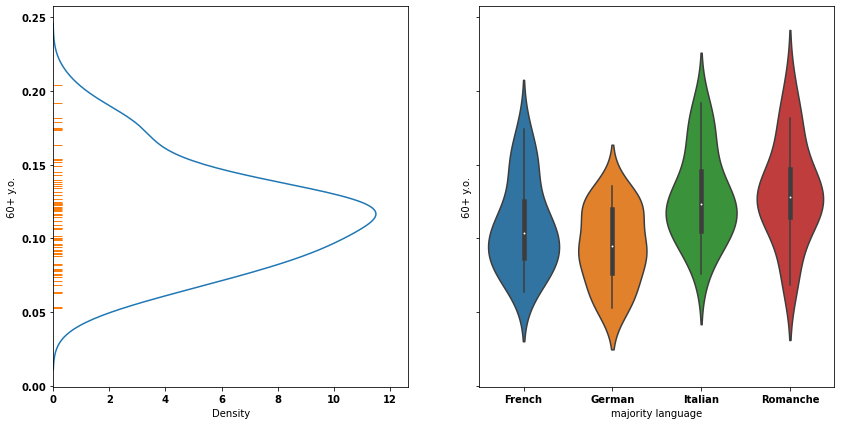

In [32]:
fig,axes = plt.subplots(1,2 , figsize=(14,7),  sharey=True )
sns.kdeplot(data=dfFractionsSample, y='60+ y.o.' , ax = axes[0] )
sns.rugplot(data=dfFractionsSample, y='60+ y.o.' , ax = axes[0] )

sns.violinplot( data=dfFractionsSample, x='majority language', y='60+ y.o.' , ax = axes[1])
_ = axes[1].set_xticks( range(4), map(lambda x:x.partition(' ')[0] , dfFractionsSample['majority language'].unique() ))
## the last line remoces the " speaker" at the end of x labels.

In [33]:
## nice trick to aggregate this data as a set of lists
aggregated60fraction = dfFractionsSample.groupby('majority language')['60+ y.o.'].agg(list)
aggregated60fraction

majority language
French speakers      [0.1064257028112449, 0.1739130434782608, 0.063...
German speakers      [0.1246376811594203, 0.0944741532976827, 0.053...
Italian speakers     [0.0958904109589041, 0.1385542168674698, 0.152...
Romanche speakers    [0.1156462585034013, 0.1451612903225806, 0.175...
Name: 60+ y.o., dtype: object

In [34]:

Fstat , pval = stats.f_oneway( *aggregated60fraction )
# equivalent to stats.f_oneway( aggregated60fraction[0] , aggregated60fraction[1] , ... )

print('automated 1-way anova / F-test:')
print('F-stat :',Fstat)
print('p-value:',pval)


automated 1-way anova / F-test:
F-stat : 6.590300422452274
p-value: 0.0005105725639617182


In [35]:
# With this, it can be nice to report the mean and standard deviation of each groups
dfFractionsSample.groupby('majority language')['60+ y.o.'].agg(['mean','std'])

,mean,std
majority language,,
French speakers,0.108322,0.030509
German speakers,0.094772,0.025665
Italian speakers,0.128571,0.030828
Romanche speakers,0.131764,0.034156


Note that the ANOVA only tests if there is at least one significant difference between groups.

If you want to test for each differences, then **after an ANOVA**, we recommend [Tukey's honestly significant difference](https://docs.scipy.org/doc/scipy-1.8.1/reference/generated/scipy.stats.tukey_hsd.html)

In [36]:
res = stats.tukey_hsd(*aggregated60fraction)
print(res)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.014     0.499    -0.012     0.039
 (0 - 2)     -0.020     0.161    -0.046     0.005
 (0 - 3)     -0.023     0.079    -0.049     0.002
 (1 - 0)     -0.014     0.499    -0.039     0.012
 (1 - 2)     -0.034     0.004    -0.059    -0.009
 (1 - 3)     -0.037     0.001    -0.062    -0.012
 (2 - 0)      0.020     0.161    -0.005     0.046
 (2 - 1)      0.034     0.004     0.009     0.059
 (2 - 3)     -0.003     0.987    -0.028     0.022
 (3 - 0)      0.023     0.079    -0.002     0.049
 (3 - 1)      0.037     0.001     0.012     0.062
 (3 - 2)      0.003     0.987    -0.022     0.028



In [37]:
## the categories Ids correspond to the order in which the lists were provided:
for i,n in enumerate(aggregated60fraction.index):
    print(i,n)

0 French speakers
1 German speakers
2 Italian speakers
3 Romanche speakers


> Of course, there exists many other tests implemented in `scipy.stats` (as well as other libraries). Here is a little [cheat-sheet](https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/) to help you explore this. 

> Scipy.stats documentation is also great!

<br>
<br>

[back to toc](#toc)

# 2. Correlation and linear regression <a id='reg'></a>
-----------------------------------------------

## 2.1 Correlation <a id='reg.1'></a>

**Correlation** is a measure of the amount of relatedness between two measured variables. It comes in several flavours :
 * **Pearson's linear correlation** coefficient: for linear relationship only: **`stats.pearsonr(x,y)`**
 * **Spearman's rank correlation** coefficient: accepts non linear, but "monotonic only":
   **`stats.spearmanr(x,y)`**
 * **Kendall's Tau**: relies on value order relation only, and is less influenced by the scale than
   the two others: **`stats.kendalltau(x,y)`**



In [ ]:
sigma=1./5

linear=[[u,(u)/100+sigma*np.random.randn()] for u in range(10,500)]
monotonic=[[u,50*(0.8**(u/10))+sigma*np.random.randn()] for u in range(10,500)]

non_monotonic=[[u,(u)**3+3*u**2+sigma*np.random.randn()] for u in np.arange(-1,1,1./250)]

together=[linear,monotonic,non_monotonic]
plt.subplots(133,figsize=(15,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    x=[u[0] for u in together[i]]
    y=[u[1] for u in together[i]]
    plt.scatter(x,y)
    plt.title('Pearson: {0:.3f}, Spearman: {1:.3f}, Kendall: {2:.3f}'.format(
                                    stats.pearsonr(x,y)[0],##just like that
                                    stats.spearmanr(x,y)[0],
                                    stats.kendalltau(x,y)[0]))
plt.tight_layout()    
plt.show()


[back to toc](#toc)

<br>

## 2.2 Regression <a id='reg.2'></a>

Performing regression (linear or otherwise) is possible with `scipy`, but it is not the best.

`statsmodels` offers much nicer options and statistical reports. Additionnally, this is a great opportunity to see together how to install a library. 

1. go to [https://www.statsmodels.org](https://www.statsmodels.org)
2. click on the install page 
3. find the instruction for installation with Anaconda 
4. type the command in either a terminal (mac, linux) or in the anaconda-prompt (windows)


In [ ]:
import statsmodels
print("Module loaded successfully!")

<br>

Let's load our data using pandas:

In [ ]:
df_diabetes = pd.read_table("data/diabetes.csv", sep=",")
df_diabetes.head()

In [ ]:
#pulling all the data together in the same dataFrame

x = df_diabetes['bmi']                  # covariable bmi
y = df_diabetes['disease progression']  # response variable disease progression


fig, ax = plt.subplots(figsize=(10,10))  # setup graphical windows
sns.scatterplot(x=x, y=y)                   # plot x versus y


In [ ]:
stats.pearsonr(df_diabetes['bmi'],
               df_diabetes['disease progression'] )

In [ ]:
## We'll be using the statsmodel package, which computes a lot of cool metrics for you
import statsmodels
import statsmodels.api as sm

X = sm.add_constant(x)## adding a intercept to the model
model = sm.OLS(y, X)  ## defining an Ordinary Least Square variable
results = model.fit() ## fitting it

print( results.summary() )

In [ ]:
## diagnostic plots :
from statsmodels.graphics.gofplots import qqplot
fig,axes = plt.subplots(1,2,figsize = (15,6))

# plotting residuals (error of the model) vs. fitted values (prediction fo the model)
# helps determine homoskedascticity and sphericity of errors  :
# the points should show about the same spread all along the x axis, and be centered around 0.
axes[0].scatter( results.fittedvalues , results.resid )
axes[0].axhline(0.0 , color = 'grey')
axes[0].set_xlabel('fitted values')
axes[0].set_ylabel('residuals')

# the QQplot (quantile-quantile plot) is  great plot to assess normality of the model's residual
# basically points should stay close to the diagonal line if they follow something close to a normal distribution.
qqplot(results.resid , ax = axes[1] , line='s') 

plt.show()



In [ ]:
###Plotting the fit
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# we obtain the predicted values for our model, as well as their 95% intervals
prstd, iv_l, iv_u = wls_prediction_std(results) 

fig, ax = plt.subplots(figsize=(10,10))

#ax.plot(x, y, 'o', label="data")
sns.scatterplot(x=x,y=y) # plot x versus y
ax.plot(x, results.fittedvalues, 'r', label="OLS regression result")
ax.plot(x, iv_u, color='orange',linestyle='--' , label='95% fit interval')
ax.plot(x, iv_l, color='orange',linestyle='--')
ax.legend(loc='best',fontsize=10)
#plt.yscale('log')

<br>
<br>
<br>

[back to toc](#toc)

# Free form exercise <a id='exo'></a>
---------------------------------

Continuing on the free-form exercise from the previous notebook, take the few associations (2?4?) which you described and see how you could test/model them.


The data is in the file `'data/heartData_simplified.csv'`

### Description of the columns

* age : Patient age in years
* sex : Patient sex
* chol : Cholesterol level in mg/dl. 
* thalach : Maxium heart rate during the stress test
* oldpeak : Decrease of the ST segment during exercise according to the same one on rest.
* ca : Number of main blood vessels coloured by the radioactive dye. The number varies between 0 to 3.
* thal : Results of the blood flow observed via the radioactive dye.
	* defect -> fixed defect (no blood flow in some part of the heart)
	* normal -> normal blood flow
	* reversible -> reversible defect (a blood flow is observed but it is not normal)
* target : Whether the patient has a heart disease or not



<br>
<br>


## Going further: using R-style formula in statsmodels

If you have been doing some regression in R, you would have come across *formula*, where instead of different dataframes for dependent variable covariables, on gives a single `DataFrame` along with a formular of the type `y ~ x`.

These offer a fairly simple and elegant way of specifying your model, with an efficient hamdling of intercepts, as well as interaction effects.

Going into details on these formula is beyond the scope of this course, but we encourage you to go though this very well made tutorial: https://www.statsmodels.org/devel/example_formulas.html